In [85]:
# External libraries
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
import requests

a_size = (16, 11)
sns.set(rc={'figure.figsize':a_size})

In [64]:
import os

from zipfile import ZipFile
from io import BytesIO

from typing import List

In [65]:
def make_confidence(mean, variance, factor = 1.64):
    N = len(mean)
    
    half_int = factor*np.sqrt(variance)
    
    confidence_intervals = np.zeros((N, 2))
    confidence_intervals[:, 0] = mean - half_int
    confidence_intervals[:, 1] = mean + half_int
        
    return confidence_intervals

In [75]:
def plot_quadrant(data, xs, datapoints = None, titles = 4*['']):
    filtered_state, variance = data[:, 0], data[:, 1]
    
    errors, prediction_variance = data[:, 2], data[:, 3]
    
    confidence_intervals = make_confidence(filtered_state, variance)  
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    if datapoints is not None:
        ax1.scatter(x_axis, datapoints)
    
    t1, t2, t3, t4 = titles
    
    ax1.set_title(t1)
    ax1.plot(x_axis, filtered_state)
    ax1.plot(x_axis, confidence_intervals[:, 0], '--')
    ax1.plot(x_axis, confidence_intervals[:, 1], '--')
    
    ax2.set_title(t2)
    ax2.plot(x_axis, variance)
    
    ax3.set_title(t3)
    ax3.plot(x_axis, errors)
    
    ax4.set_title(t4)
    ax4.plot(x_axis, prediction_variance)
    
    plt.show()

## Assignment - Part 2

In [76]:
def read_dat(dat_string: List[str]) -> np.array:
    data = []
    for line in dat_string:
        invalid = len(line) < 1 or '//' in line
        if invalid: continue
        
        datum_str = line.replace('\n', '')
        data.append(np.float(datum_str))
        
    return np.array(data)
        

In [77]:
def get_data(path='', remote_url = 'http://www.ssfpack.com/files/DK-data.zip'):
    filepath = os.path.join(path, "Nile.dat")
    
    if os.path.isfile(filepath):
        with open(filepath, 'r') as file:
            out = file.readlines()
        return read_dat(out)
            
    else:
        r = requests.get(remote_url, stream=True)
        with ZipFile(BytesIO(r.content)) as zipped_data:
            with zipped_data.open('Nile.dat') as nile:
                out = [line.decode("utf-8") for line in nile.readlines()]
        
        return read_dat(out)

In [78]:
data = get_data('data')
base_year = 1871
end_year = base_year+len(data)

### Local level Kalman Filter

In [184]:
def neg_log_likelihood(filtered):
    
    v, F = filtered[:, 2], filtered[:, 3]

    mean = np.sum(np.abs(F))
    var = np.sum(np.square(v)/F)
    L = 0.5*(mean+var)
    if L == np.nan:
        breakpoint()
    return L

In [185]:
 def KF_step(var_eps, var_eta):
        def step(y, a, P, prev_v, prev_F):
            v = y - a
            F = P + var_eps
            K = P / F

            a_prime = a + K*v
            P_prime = P*(1-K) + var_eta

            return a_prime, P_prime, v, F
        return step
    
def KF(series, a_init, P_init, var_eps, var_eta):
    
    T = len(series)
    filtered = np.zeros((T+1, 4))

    filtered[0] = [a_init, P_init, None, None]
    step = KF_step(var_eps, var_eta)
    
    for t, y in enumerate(series):
        a_prime, P_prime, v, F = step(y, *filtered[t])
        filtered[t, 2:] = [v, F]
        filtered[t+1, :2] = [a_prime, P_prime]
        

    return filtered[1:-1]

In [198]:
positive_bounds = ((0, None), (0, None))
def max_likelihood_KF(series, a_init, P_init, var_eps=None, var_eta=None, verbose=False):
    
    if var_eps is None or var_eta is None:
        if verbose: print("Estimating with Maximum Likelihood...")
        res = opt.minimize(
            lambda params: neg_log_likelihood(
                KF(series, a_init, P_init, *params)
            ),
            [10_000, 1_000], bounds=positive_bounds
        )
        var_eps, var_eta = res.x
        
        if not res.success:
            #raise ValueError(f'Var_eps={var_eps}, Var_eta={var_eta}\n{res.message}')
            print("error", res.message)
            
        if verbose:
            print(f"Var_eps={var_eps}, Var_eta={var_eta}")

    return KF(series, a_init, P_init, var_eps, var_eta), var_eps, var_eta

### Figure 2.1

In [199]:
params = { 'var_eps': 15_099., 'var_eta': 1_469.1 } 
init = { 'a_init': 0, 'P_init': 10e7 }

In [200]:
filtered, var_eps, var_eta = max_likelihood_KF(data, **init, **params, verbose=True)

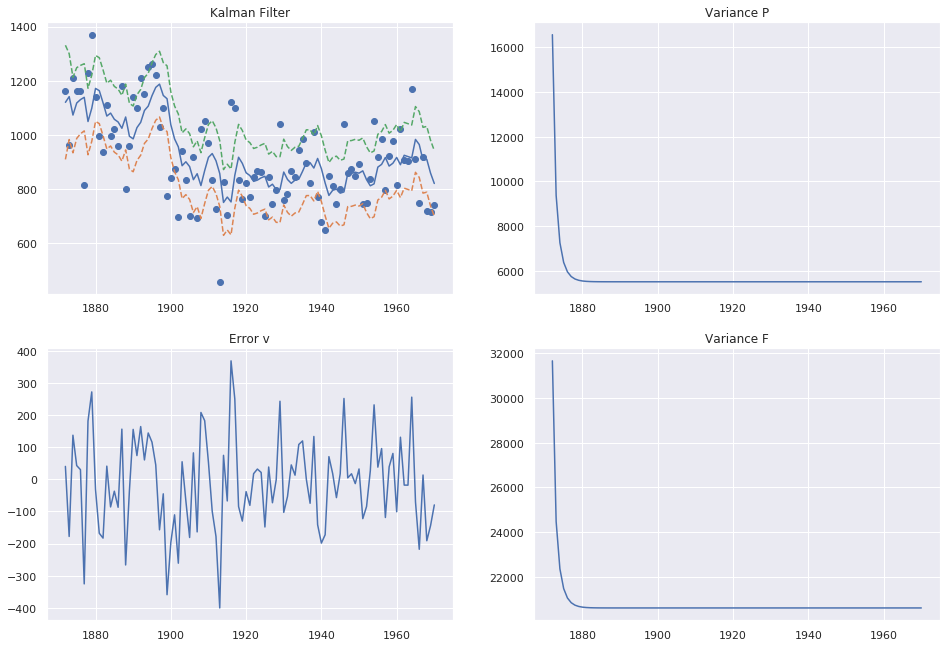

In [201]:
x_axis = range(base_year+1, end_year)
plot_quadrant(filtered, x_axis,
              datapoints=data[1:],
              titles=["Kalman Filter", "Variance P", "Error v", "Variance F"])

### State Smoothing

In [314]:
def KF_smoothing(series, *kf_args, **kf_kwargs):
    
    filtered, var_eps, var_eta = max_likelihood_KF(series, *kf_args, **kf_kwargs)
    v, F = filtered[:, 2], filtered[:, 3]
    r = np.zeros((filtered.shape[0] + 1))
    L = var_eps / F
    
    for t, r_t in enumerate(r[:-1]):
        pass